# INF8245E - Assignment 2
### Author : Guillaume Jones
### Date : 2021-10-24

## 1. Linear Classification and Nearest Neighbor Classification

In [4]:
# Question 1 : Generate multivariate Gaussian distribution, label and split

import csv
import numpy as np

parameters_filepath = 'Assignment2_1952504_'

def openArray(filename, transpose=True):
    # Opens a .csv format file as np array
    with open(filename) as file:
        dataset_reader = csv.reader(file)
        dataset = np.array(list(dataset_reader))
        if transpose:
            dataset = np.transpose(dataset)
            dataset = dataset[:-1] # Removes trailing ',' column
        else:
            dataset = dataset[:, :-1] # Removes trailing ',' column
        return dataset.astype(float)

def saveDataset(filename, array):
    # Outputs a np array in .csv format
    # Format is based on Assignment 1 datasets
    np.savetxt(filename, array, delimiter = ',', fmt='%.11f', newline=',\n')

def splitBinaryDataset(class1, class2, distribution):
    # Combines two classes of a binary dataset and splits according to distribution dictionary
    split_dataset = {}
    cum_frac = 0
    class1_len = class1.shape[0]
    class2_len = class2.shape[0]

    # Since they were generated at random, selecting continuous blocks is ok
    for (label, fraction) in distribution.items():
        split_dataset[label] = np.concatenate((
            class1[int(class1_len * cum_frac) : int(class1_len * (cum_frac + fraction))], 
            class2[int(class2_len * cum_frac) : int(class2_len * (cum_frac + fraction))]))
        cum_frac += fraction
    
    return split_dataset

# Import mean and covariance matrix 
DS1_covariance = openArray('data_params/DS1_Cov.txt')
DS1_mean0 = openArray('data_params/DS1_m_0.txt')[:, 0]
DS1_mean1 = openArray('data_params/DS1_m_1.txt')[:, 0]

# Generate distributions and assign labels
examples = 2000
distribution = {'train': 0.6, 'valid': 0.2, 'test': 0.2}
DS1_class0 = np.c_[np.random.multivariate_normal(DS1_mean0, DS1_covariance, examples), -np.ones(examples)]
DS1_class1 = np.c_[np.random.multivariate_normal(DS1_mean1, DS1_covariance, examples), np.ones(examples)]

# Select train, valid and test examples
DS1_split = splitBinaryDataset(DS1_class0, DS1_class1, distribution)

# Saves DS1 in same format as Assignment 1 datasets
for (sectionName, DS1_section) in DS1_split.items():
    saveDataset('datasets/DS1_' + sectionName + '.txt', DS1_section)

In [5]:
# GDA functions

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def binaryGDA(x, mean1, mean2, covariance, prior_probability):
    # Calculate binary GDA probability and return class
    covarianceInv = np.linalg.inv(covariance)
    w = np.dot(covarianceInv, (mean1 - mean2))
    w0 = -0.5 * np.dot(np.transpose(mean1), np.dot(covarianceInv, mean1)) \
        + 0.5 * np.dot(np.transpose(mean2), np.dot(covarianceInv, mean2)) \
        + np.log(prior_probability)
    
    probabilities = sigmoid(np.dot(x, w) + w0)
    # Applies threshold of 0 (since binary) to probabilities
    return (probabilities > 0.5).astype(int) * 2 - 1, w0, w

def calculateBinaryGDAParameters(x):
    # GDA parameters calculated using maximum likelihood equations
    x1 = x[x[:,-1] == 1, :-1]
    x2 = x[x[:,-1] == -1, :-1]
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    n = n1 + n2

    mean1 = np.mean(x1, axis=0)
    mean2 = np.mean(x2, axis=0)

    covariance = 1 / n * np.dot(np.transpose(x1 - mean1), (x1 - mean1)) + 1 / n * np.dot(np.transpose(x2 - mean2), (x2 - mean2))

    prior_probability = n1 / n

    return mean1, mean2, covariance, prior_probability

def classification_accuracy(predicted_y, true_y):
    # Compare predicted to true and return average as accuracy
    correct_predictions = (predicted_y == true_y).astype(int)
    return np.mean(correct_predictions)

def isolateXY(dataset):
    return dataset[:, :-1], dataset[:, -1]


In [6]:
# Question 2 : GDA on DS1

DS1_train = openArray('datasets/DS1_train.txt', transpose=False)
DS1_valid = openArray('datasets/DS1_valid.txt', transpose=False)
DS1_test = openArray('datasets/DS1_test.txt', transpose=False)

DS1_test_x, DS1_test_y = isolateXY(DS1_test)
DS1_train_x, DS1_train_y = isolateXY(DS1_train)
DS1_valid_x, DS1_valid_y = isolateXY(DS1_valid)

DS1_m1, DS1_m2, DS1_cov, DS1_pp = calculateBinaryGDAParameters(DS1_train)

DS1_GDA_test_predictions, DS1_w0, DS1_w = binaryGDA(DS1_test_x, DS1_m1, DS1_m2, DS1_cov, DS1_pp)

DS1_GDA_test_accuracy = classification_accuracy(DS1_GDA_test_predictions, DS1_test_y)
print(f'DS1 accuracy with GDA: {DS1_GDA_test_accuracy:.2%}')

DS1_coefficients = np.insert(DS1_w, 0, DS1_w0)
saveDataset(parameters_filepath + '1_2.txt', DS1_coefficients)

DS1 accuracy with GDA: 96.38%


In [70]:
# k-NN functions

from scipy import stats
import matplotlib.pyplot as plt

def knn(new_x, train_x, train_y, ks):
    # Returns k-nn calculated class
    new_x_t = new_x[:, np.newaxis]
    difference = np.subtract(train_x, new_x_t)
    distances = np.einsum('ij,ij->j', difference, difference)

    predictions = []
    sorted_distances_indexes = np.argsort(distances, axis=0)
    for k in ks:
        predictions.append(stats.mode(train_y[sorted_distances_indexes[:k]])[0][0])
    return predictions

def batch_knn(new_x_batch_t, new_x_batch_2, train_x, train_x_2, train_y, ks):
    distances = np.dot(train_x, new_x_batch_t) * -2
    distances = distances + new_x_batch_2[np.newaxis, :] + train_x_2[:, np.newaxis]
    
    sorted_distances_indexes = np.argsort(distances, axis=0)

    predictions = np.empty((0, new_x_batch_t.shape[1]))
    for k in ks:
        modes = stats.mode(train_y[sorted_distances_indexes[:k, :]], axis=0)[0][0][np.newaxis, :]
        predictions = np.concatenate((predictions, modes))
    return np.transpose(predictions)


def knn_predictions(new_x_set, train_x, train_y, ks, batch_size=100):
    # Applies binary knn to entire dataset of x values
    train_x_2 = np.sum(train_x**2, axis = 1)

    new_x_predictions = np.empty((0, len(ks)))
    i = 0
    for i in np.arange(0, new_x_set.shape[0], batch_size):
        new_x_batch = new_x_set[i : i+batch_size]
        new_x_batch_2 = np.sum(new_x_batch**2, axis = 1)
        new_x_batch_t = np.transpose(new_x_batch)


        batch_predictions = batch_knn(new_x_batch_t, new_x_batch_2, train_x, train_x_2, train_y, ks)
        new_x_predictions = np.concatenate((new_x_predictions, batch_predictions))
    return new_x_predictions



def validateDifferentK(train_x, train_y, valid_x, valid_y, ks, batch_size=100):
    valid_accuracies = {}
    best_k = 0
    best_accuracy = 0
    valid_predictions = knn_predictions(valid_x, train_x, train_y, ks, batch_size)

    for index, k in enumerate(ks):
        valid_accuracies[k] = classification_accuracy(valid_predictions[:, index], valid_y)
        if valid_accuracies[k] > best_accuracy:
            best_accuracy = valid_accuracies[k]
            best_k = k
    return valid_accuracies, best_k

def plotAccuracyAgainstK(k_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(k_accuracies.keys(), k_accuracies.values())
    plt.xlabel('k')
    plt.ylabel('Validation accuracy')
    plt.show()

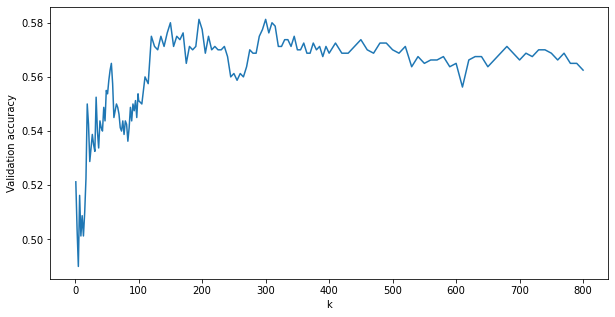

DS1 best k: 195
DS1 best accuracy with k-nn, k=195: 55.75%


In [73]:
# Question 3 : k-NN on DS1

k_values = list(np.arange(1, 100, 2)) + list(np.arange(100, 400, 5)) + list(np.arange(400, 801, 10))
DS1_knn_valid_accuracies, DS1_best_k = validateDifferentK(DS1_train_x, DS1_train_y, DS1_valid_x, DS1_valid_y, k_values, 800)

plotAccuracyAgainstK(DS1_knn_valid_accuracies)

print(f'DS1 best k: {DS1_best_k}')

DS1_knn_test_accuracy = classification_accuracy(knn_predictions(DS1_test_x, DS1_train_x, DS1_train_y, [DS1_best_k], 800)[:, 0], DS1_test_y)

print(f'DS1 best accuracy with k-nn, k={DS1_best_k}: {DS1_knn_test_accuracy:.2%}')

In [24]:
# Question 4 : Generate mixed multivariate Gaussian dataset DS2, label and split

def generateMixedMultiGaussian(means, covariances, probabilities, n):
    # Generates samples from mixed multivariate gaussians
    samples = np.empty((0, 20))
    # Adds n*probability samples of each multivariate gaussian to samples[]
    for mean, covariance, probability in zip(means, covariances, probabilities):
        generated = np.random.multivariate_normal(mean, covariance, int(n * probability))
        samples = np.concatenate((samples, generated))

    return samples

DS2_covariances = []
DS2_means1 = []
DS2_means2 = []

# Import mean and covariance matrices for both classes and all 3 Gaussians
for i in range(1, 4):
    DS2_covariances.append(openArray(f'data_params/DS2_Cov{i}.txt'))
    DS2_means1.append(openArray(f'data_params/DS2_c1_m{i}.txt')[:, 0])
    DS2_means2.append(openArray(f'data_params/DS2_c2_m{i}.txt')[:, 0])

# Generate mixed multivariate gaussian distributions
probabilities = [0.1, 0.42, 0.48]
DS2_class1 = np.c_[generateMixedMultiGaussian(DS2_means1, DS2_covariances, probabilities, examples), -np.ones(examples)]
DS2_class2 = np.c_[generateMixedMultiGaussian(DS2_means2, DS2_covariances, probabilities, examples), np.ones(examples)]

# Split into train, valid, test with same proportions as before
DS2_split = splitBinaryDataset(DS2_class1, DS2_class2, distribution)

# Saves DS2 in same format as Assignment 1 datasets
for (sectionName, DS2_section) in DS2_split.items():
    saveDataset(f'datasets/DS2_{sectionName}.txt', DS2_section)

In [25]:
# Question 5.1 : GDA on DS2

DS2_train = openArray('datasets/DS2_train.txt', transpose=False)
DS2_valid = openArray('datasets/DS2_valid.txt', transpose=False)
DS2_test = openArray('datasets/DS2_test.txt', transpose=False)

DS2_train_x, DS2_train_y = isolateXY(DS2_train)
DS2_test_x, DS2_test_y = isolateXY(DS2_test)
DS2_valid_x, DS2_valid_y = isolateXY(DS2_valid)

DS2_m1, DS2_m2, DS2_cov, DS2_pp = calculateBinaryGDAParameters(DS2_train)

DS2_GDA_test_predictions, DS2_w0, DS2_w = binaryGDA(DS2_test_x, DS2_m1, DS2_m2, DS2_cov, DS2_pp)
DS2_GDA_test_accuracy = classification_accuracy(DS2_GDA_test_predictions, DS2_test_y)
print(f'DS2 accuracy with GDA: {DS2_GDA_test_accuracy:.2%}')

DS2_coefficients = np.insert(DS2_w, 0, DS2_w0)
saveDataset(parameters_filepath + '1_5_1.txt', DS2_coefficients)

DS2 accuracy with GDA: 49.75%


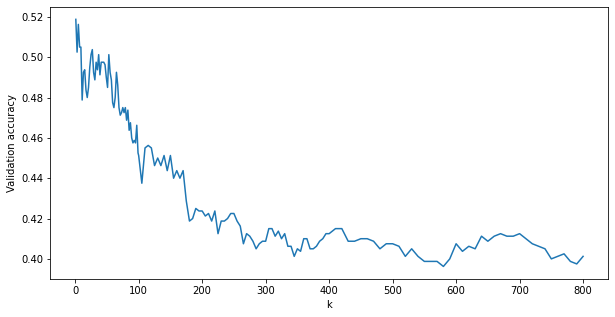

DS2 best k on validation set: 1
DS2 best test accuracy with k-nn, k=1: 44.88%


In [74]:
# Question 5.2 : k-nn on DS2

k_values = list(np.arange(1, 100, 2)) + list(np.arange(100, 400, 5)) + list(np.arange(400, 801, 10))
DS2_knn_valid_accuracies, DS2_best_k = validateDifferentK(DS2_train_x, DS2_train_y, DS2_valid_x, DS2_valid_y, k_values, 800)

plotAccuracyAgainstK(DS2_knn_valid_accuracies)

print(f'DS2 best k on validation set: {DS2_best_k}')

DS2_knn_predictions = knn_predictions(DS2_test_x, DS2_train_x, DS2_train_y, [DS1_best_k])[:, 0]
DS2_knn_test_accuracy = classification_accuracy(DS2_knn_predictions, DS2_test_y)

print(f'DS2 best test accuracy with k-nn, k={DS2_best_k}: {DS2_knn_test_accuracy:.2%}')

## 2. MNIST Handwritten Digits Classification

In [1]:
# Import Keras
from tensorflow import keras
# Loading the mnist dataset
(mnist_train_valid_x, mnist_train_valid_y), (mnist_test_x, mnist_test_y) = keras.datasets.mnist.load_data()

# Flatten to 784 features
mnist_train_valid_x = mnist_train_valid_x.reshape(mnist_train_valid_x.shape[0], -1)
mnist_test_x = mnist_test_x.reshape(mnist_test_x.shape[0], -1)

# Normalize to [0, 1]
mnist_train_valid_x = mnist_train_valid_x / 255.0
mnist_test_x = mnist_test_x / 255.0

# Split train/valid
mnist_train_x = mnist_train_valid_x[:50000]
mnist_valid_x = mnist_train_valid_x[50000:]
mnist_train_y = mnist_train_valid_y[:50000]
mnist_valid_y = mnist_train_valid_y[50000:]

11501568/11490434 [==============================] - 1s 0us/step


In [31]:
# Question 1: GNB on MNIST dataset

def softmax(x_vector):
    return np.exp(x_vector) / np.sum(np.exp(x_vector))

def multiGNB(all_x, all_means, all_variances, all_prior_probabilities, all_sizes):
    # Returns most likely classes using GNB assumptions

    all_probabilities = np.empty((all_x.shape[0], 0))
    # Iterates through each class
    for class_means, class_variances, pp, class_size in zip(all_means, all_variances, all_prior_probabilities, all_sizes):
        stds = np.sqrt(class_variances)
        smoothing_add = 1 / class_size
        smoothing_multiply = 0.002 * (1 - smoothing_add)

        class_probabilities = np.full(all_x.shape[0], np.log(pp))
        # Iterates through all features to obtain distributions
        for index, (mean, std) in enumerate(zip(class_means, stds)):
            if std == 0:
                # If variance is 0, uses uniform distribution 
                # This gives 1 for x ~= mean, and Laplace smoothing elsewhere
                class_probabilities += np.log((stats.uniform(mean - 0.001, 0.002).pdf(all_x[:, index])*smoothing_multiply + smoothing_add))
            else:
                # Using log() to prevent underflow/overflow on multiplication
                # Tiny value to prevent log(0) in certain cases
                class_probabilities += np.log(stats.norm(mean, std).pdf(all_x[:, index]))
        
        all_probabilities = np.c_[all_probabilities, class_probabilities]
        
    return np.argmax(all_probabilities, axis=1)


def calculateMultiGNBParameters(separated_x, n):
    # Calculates GNB parameters for multi-class prediction
    # separated_x is list of ndarray with shape (#samples, #features)
    # each ndarray contains elements of only 1 class
    means = []
    covariances = []
    prior_probabilities = []
    class_sizes = []
    for x_class in separated_x:
        n_class = x_class.shape[0]
        class_sizes.append(n_class)

        means.append(np.mean(x_class, axis=0))
        covariance = np.var(x_class, axis=0)
        covariances.append(covariance)
        
        prior_probabilities.append(n_class / n)

    return means, covariances, prior_probabilities, class_sizes

def separateClasses(x, y):
    # Splits dataset according to classes
    class_labels = np.unique(y)
    separated_x = []
    for label in class_labels:
        separated_x.append(x[y[:] == label, :])

    return separated_x


In [30]:
mnist_train_x_sep = separateClasses(mnist_train_x, mnist_train_y)
mnist_means, mnist_variances, mnist_pp, mnist_class_sizes = calculateMultiGNBParameters(mnist_train_x_sep, 50000)

mnist_gnb_predictions = multiGNB(mnist_test_x, mnist_means, mnist_variances, mnist_pp, mnist_class_sizes)

mnist_accuracy = classification_accuracy(mnist_gnb_predictions, mnist_test_y)
print(f'GNB accuracy on MNIST: {mnist_accuracy:.2%}')

C:\Users\guill\AppData\Local\Temp/ipykernel_10476/1959398386.py:26: RuntimeWarning: divide by zero encountered in log
  class_probabilities += np.log(stats.norm(mean, std).pdf(all_x[:, index]))


GNB accuracy on MNIST: 77.56%


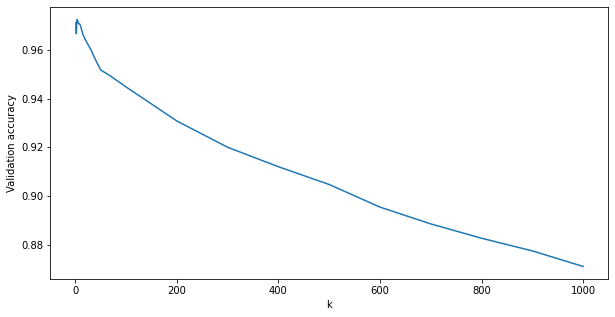

MNIST best k on validation set: 4


In [80]:
# Question 2 : k-nn on MNIST

k_values = list(np.arange(1, 10, 1)) + list(np.arange(10, 20, 5)) + list(np.arange(20, 80, 10)) + list(np.arange(100,1001, 100))
mnist_knn_valid_accuracies, mnist_best_k = validateDifferentK(
    mnist_train_x[:], mnist_train_y[:], 
    mnist_valid_x[:], mnist_valid_y[:], k_values, 2000)

plotAccuracyAgainstK(mnist_knn_valid_accuracies)

print(f'MNIST best k on validation set: {mnist_best_k}')

In [81]:
mnist_knn_predictions = knn_predictions(mnist_test_x, mnist_train_x[:], mnist_train_y[:], [mnist_best_k], 2000)[:, 0]
mnist_knn_test_accuracy = classification_accuracy(mnist_knn_predictions, mnist_test_y)

print(f'MNIST best test accuracy with k-nn, k={mnist_best_k}: {mnist_knn_test_accuracy:.2%}')

MNIST best test accuracy with k-nn, k=4: 96.58%
